### HWE Unit Test Development

In [ ]:
import ctypes
import numpy as np
import pandas as pd
from sgkit.stats.hwe import hardy_weinberg_p_value_jit as hwep

In [1]:
import glob
from pathlib import Path

In [3]:
glob.glob(str(Path('data')/ '*'))

['data/sim_01.csv']

In [3]:
!make clean
!make

rm -f *.o *.so 
gcc -c -Wall -Werror -fpic chwe.c
gcc -shared -o libchwe.so chwe.o


In [4]:
libc = ctypes.CDLL("./libchwe.so")
chwep = libc.hwep
chwep.restype = ctypes.c_double

In [9]:
chwep(57, 14, 50)

0.8422797565707926

In [10]:
hwep(57, 14, 50)

0.8422797565707925

### Scalar Tests

In [12]:
rs = np.random.RandomState(0)
n, s = 10_000, 50
n_het = np.expand_dims(np.arange(n, step=s) + 1, -1)
frac = rs.uniform(.3, .7, size=(n // s, 2))
n_hom = frac * n_het
n_hom = n_hom.astype(int)
args = np.concatenate((n_het, n_hom), axis=1)
args[:5]

array([[  1,   0,   0],
       [ 51,  27,  26],
       [101,  47,  56],
       [151,  71,  99],
       [201, 137,  91]])

In [13]:
import pandas as pd
import time
df = []
for i in range(args.shape[0]):
    a = [int(x) for x in args[i]]
    p1 = chwep(a[0], a[1], a[2])
    p2 = hwep(a[0], a[1], a[2])
    df.append(dict(
        p_true=p1,
        p_pred=p2
    ))
df = pd.DataFrame(df)

In [14]:
df.head()

,p_true,p_pred
0,1.000000,1.000000
1,0.845927,0.845927
2,0.889304,0.889304
3,0.368487,0.368487
4,0.283442,0.283442


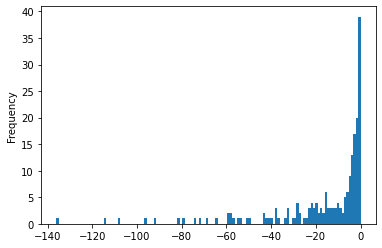

In [15]:
df['p_true'].apply(np.log10).plot(kind='hist', bins=128)

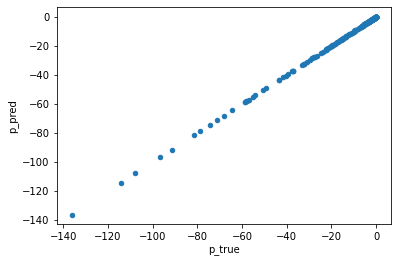

In [16]:
(
    df
    .assign(
        p_true=lambda df: np.log10(df['p_true']),
        p_pred=lambda df: np.log10(df['p_pred'])
    )
    .plot(kind='scatter', x='p_true', y='p_pred')
)

In [17]:
np.testing.assert_allclose(df['p_true'], df['p_pred'])

In [18]:
df['p_true'].values

array([1.00000000e+000, 8.45926829e-001, 8.89304245e-001, 3.68487492e-001,
       2.83442131e-001, 1.93780506e-001, 3.46415612e-002, 9.77805142e-007,
       9.00169099e-002, 2.77392776e-004, 5.78595078e-006, 1.56290046e-001,
       3.11983705e-002, 7.78234779e-001, 6.28255056e-001, 9.17242816e-001,
       8.81087089e-001, 1.20954751e-004, 6.51960684e-002, 4.87927509e-007,
       6.14320396e-002, 1.67216769e-003, 2.58323982e-003, 9.22666204e-012,
       1.15591803e-003, 1.00000000e+000, 5.21303203e-001, 2.40595832e-012,
       1.79017126e-001, 8.50964237e-004, 4.08782584e-018, 2.65625649e-003,
       1.73047163e-007, 2.61257337e-002, 3.40282167e-002, 5.57265342e-006,
       2.28187711e-010, 3.71009969e-005, 2.02796027e-015, 2.85690782e-015,
       4.43715904e-004, 1.24880234e-005, 1.39680904e-002, 6.69133747e-009,
       9.43219724e-010, 6.10161450e-001, 1.93499955e-003, 1.44451527e-014,
       1.15651799e-011, 6.16416362e-006, 2.18519190e-001, 2.67902896e-020,
       3.81265044e-003, 1

In [19]:
hwep(0, 0, 0)

nan

In [22]:
for n_het in 10**np.arange(3, 8):
    p1 = hwep(n_het, n_het//2, n_het//2)
    p2 = hwep(n_het, n_het//10, n_het//2 + n_het//10)
    print(n_het, p1, p2)

1000 0.9999999999999996 2.423934816528403e-34
10000 1.0 0.0
100000 0.9999999999999997 0.0
1000000 1.0 0.0
10000000 1.0 0.0


### Vectorized Tests

In [2]:
from typing import Optional
from sgkit import create_genotype_call_dataset
from sgkit.stats.hwe import hardy_weinberg_test
from sgkit.tests.test_hwe import to_genotype_call_dataset, simulate_genotype_calls
gt_dist = [0.25, 0.5, 0.25]
call_genotype = simulate_genotype_calls(50, 1000, p=gt_dist)
ds = to_genotype_call_dataset(call_genotype)
ds = ds.merge(hardy_weinberg_test(ds))
ds

<xarray.Dataset>
Dimensions:              (alleles: 2, ploidy: 2, samples: 1000, variants: 50)
Dimensions without coordinates: alleles, ploidy, samples, variants
Data variables:
    variant/contig       (variants) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    variant/position     (variants) int64 0 1 2 3 4 5 6 ... 43 44 45 46 47 48 49
    variant/alleles      (variants, alleles) |S1 b'T' b'C' b'T' ... b'T' b'C'
    sample/id            (samples) <U4 'S0' 'S1' 'S2' ... 'S997' 'S998' 'S999'
    call/genotype        (variants, samples, ploidy) int64 1 0 1 0 0 ... 0 0 1 1
    call/genotype_mask   (variants, samples, ploidy) bool False False ... False
    variant/hwe_p_value  (variants) float64 dask.array<chunksize=(50,), meta=np.ndarray>
Attributes:
    contigs:  [0]

In [5]:
p = ds['variant/hwe_p_value'].values
p

array([0.84965934, 0.16354278, 0.07601487, 0.5275052 , 0.6128462 ,
       1.        , 0.70306802, 0.94962855, 0.41039482, 0.56905156,
       0.01141049, 0.04312044, 0.16446281, 0.34292471, 0.65827469,
       0.65828459, 0.7046632 , 0.41143553, 1.        , 0.56913128,
       0.80049101, 0.75171363, 0.18377625, 0.34334841, 0.16443965,
       0.94961921, 0.41048285, 0.11418474, 0.89944443, 0.48613015,
       0.84946805, 0.31078525, 0.03701711, 0.61322632, 0.48702148,
       0.94963516, 0.89943975, 0.48450522, 0.56908112, 0.28101448,
       0.00194671, 0.80023881, 0.44766596, 0.23003134, 0.44829854,
       0.44830607, 0.84946805, 0.4094545 , 0.37569028, 0.22925408])

In [8]:
import xarray as xr
xr.Dataset({'x': ('ploidy', np.zeros(3))})

<xarray.Dataset>
Dimensions:  (ploidy: 3)
Dimensions without coordinates: ploidy
Data variables:
    x        (ploidy) float64 0.0 0.0 0.0

In [6]:
p.min(), p.max()

(0.0019467095399049773, 1.0)